In [1]:
%%html
<style>
table {float:left}
</style>

## Tf-Idf & Multinomial NB

- tokenizing/POS tagging $\rightarrow$ tf-idf vectorization
- Model: Multinomial Naive Bayes
- Data: 165,810 reviews

### Modeling

- Without Oversampling
- With Oversampling

### Results

|                      | Accuracy | Recall | F1-Score |
|----------------------|:--------:|:------:|:--------:|
| Without Oversampling |   0.77   |  0.77  |   0.77   |
| With Oversampling    |   0.74   |  0.73  |   0.73   |

- Before oversampling, recall of 역겹다/슬프다/무섭다 is lower than precision.
- After oversampleing, recall of those labels is improved.

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
from collections import Counter

from file_io import *
from words_preprocessing import *

In [3]:
train_joy = read_data('../train_data_labeled_joy.txt')
train_anger = read_data('../train_data_labeled_anger.txt')
train_disgust = read_data('../train_data_labeled_disgust.txt')
train_sadness = read_data('../train_data_labeled_sadness.txt')
train_fear = read_data('../train_data_labeled_fear.txt')

trains = [train_joy, train_anger, train_disgust, train_sadness, train_fear]
labels = ['기쁘다', '화나다', '역겹다', '슬프다', '무섭다']

num_dic = {}
for label, data in zip(labels, trains):
    num_dic[label] = len(data)
label_count = Counter(num_dic)
sum_ = sum(label_count.values())
print("Number of Data: ", sum_)
print(label_count)
print()

for label in label_count.keys():
    print(label ,": {}%".format(round(label_count[label] / sum_, 2)))

Number of Data:  165810
Counter({'기쁘다': 73614, '화나다': 40501, '슬프다': 20701, '역겹다': 20390, '무섭다': 10604})

기쁘다 : 0.44%
화나다 : 0.24%
역겹다 : 0.12%
슬프다 : 0.12%
무섭다 : 0.06%


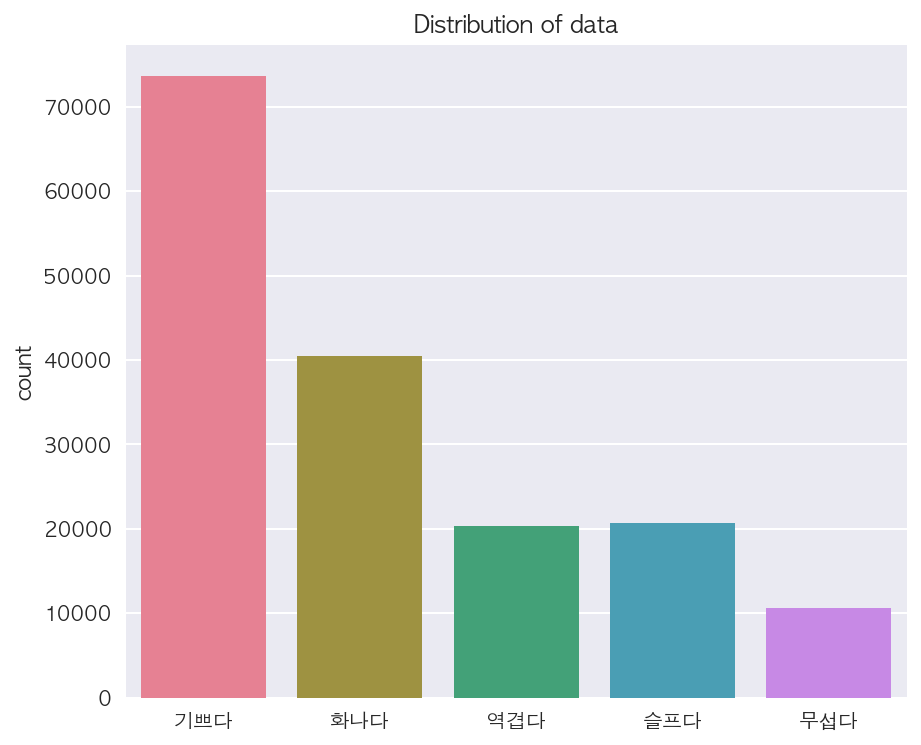

In [4]:
df = pd.DataFrame(list(label_count.values()), 
                  index=list(label_count.keys()), 
                  columns=['count'])

plt.figure(figsize=(7, 6))
plt.title("Distribution of data")
sns.barplot(x=df.index, y=df['count'], data=df, palette='husl');

- Imbalanced distribution of labels.
    1. Number of reviews of horror movies are small.
    2. Most of positive emotions are labeled as 기쁘다.

In [5]:
train = load_pickle('../train_data.pkl')
test = load_pickle('../test_data.pkl')

In [6]:
len(train), len(test)

(149230, 16580)

## 1. Without Oversampling

In [7]:
%%time
train_docs = [(tokenize(row[0][0]), row[1]) for row in train]
test_docs = [(tokenize(row[0][0]), row[1]) for row in test]

CPU times: user 3min 5s, sys: 957 ms, total: 3min 6s
Wall time: 2min 54s


In [8]:
save_pickle('../train_docs.pkl', train_docs)
save_pickle('../test_docs.pkl', train_docs)

In [9]:
y0 = [row[1] for row in train_docs]
x0 = [' '.join(row[0]) for row in train_docs]

X_train, X_test, y_train, y_test = train_test_split(x0, y0, 
                                                    random_state=1234)

len(X_train), len(X_test), len(y_train), len(y_test)

(111922, 37308, 111922, 37308)

In [10]:
clf = Pipeline([
    ('vect', TfidfVectorizer(min_df=10, ngram_range=(1, 3))), 
    ('clf', MultinomialNB(alpha=0.001)),    
])

model = clf.fit(X_train, y_train)
model

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=10,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
 ...e,
        vocabulary=None)), ('clf', MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True))])

In [11]:
%%time
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X_train, y_train, cv=5)
print("Cross validation score: {}".format(scores))

Cross validation score: [ 0.77441258  0.77163279  0.77184596  0.77568799  0.77621409]
CPU times: user 48.2 s, sys: 1.54 s, total: 49.7 s
Wall time: 49.7 s


In [12]:
y_pred = model.predict(X_test)

In [13]:
conf_mx = confusion_matrix(y_test, y_pred)
print(conf_mx)

[[14509   861   252   659   167]
 [ 1234  7170   427   209   150]
 [  510   916  2986   113    42]
 [ 1231   439    96  2852    58]
 [  451   415    95   121  1345]]


In [14]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.81      0.88      0.84     16448
          1       0.73      0.78      0.76      9190
          2       0.77      0.65      0.71      4567
          3       0.72      0.61      0.66      4676
          4       0.76      0.55      0.64      2427

avg / total       0.77      0.77      0.77     37308



### Validation Set에 대한 예측 결과 시각화 - heatmap

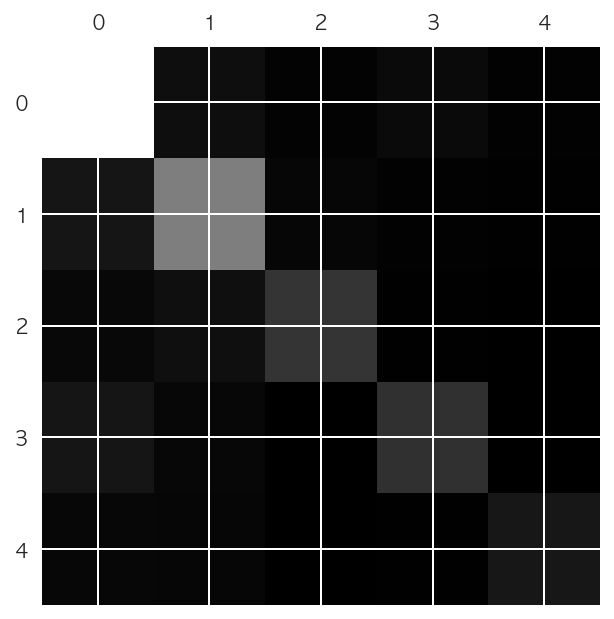

In [15]:
plt.figure(figsize=(5, 5))
plt.matshow(conf_mx, cmap=plt.cm.gray, fignum=1)
plt.show()

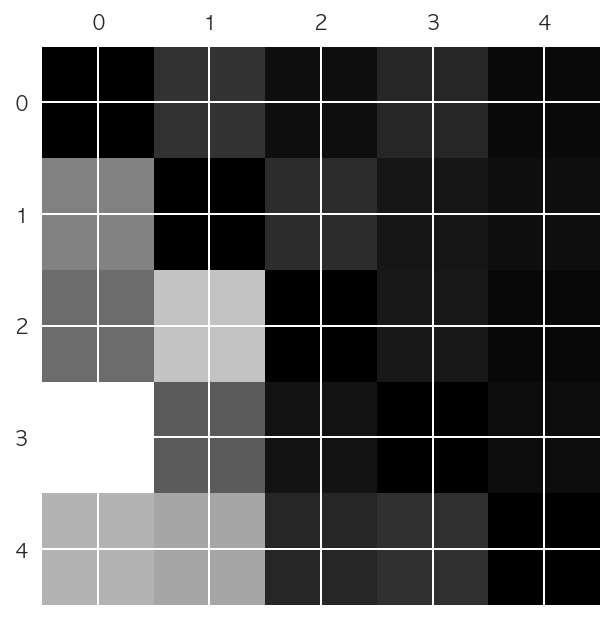

In [16]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.figure(figsize=(5, 5))
plt.matshow(norm_conf_mx, cmap=plt.cm.gray, fignum=1)
plt.show()

- Confusion Matrix 시각화 분석
    - '기쁘다'를 제외한 나머지 감정에서 잘못 분류된 대부분의 경우가 '기쁘다'로 분류된 경우
    - 특히 '역겹다'의 경우 그 비율이 큼

In [17]:
test_sadness = []
for sentence, tag in zip(X_test, y_test):
    if tag == 3:
        test_sadness.append(sentence)
        
test_joy_predict = []
for sentence, tag in zip(X_test, y_pred):
    if tag == 0:
        test_joy_predict.append(sentence)
        
predict_sad_joy = list(set(test_joy_predict).intersection(set(test_sadness)))

In [18]:
for _, sent in enumerate(predict_sad_joy[:100:10]):
    pprint(sent)

('이/Noun 시대/Noun 에/Josa 사람/Noun 의/Josa 마음/Noun 을/Josa 한편/Noun 의/Josa 그림/Noun '
 '으로/Josa 표현/Noun 하다/Verb 정말/Noun 아름답다/Adjective 대단하다/Adjective ./Punctuation')
'이모/Noun 죽/Noun 을/Josa 때/Noun 5/Number 초도/Noun 안/VerbPrefix 슬퍼하다/Verb'
'삶/Noun 의/Josa 소중하다/Adjective 만화/Noun 를/Josa 보고/Noun 깨닫다/Verb .../Punctuation'
('재미/Noun 는/Josa 분명하다/Adjective 있다/Adjective 좀/Noun 더/Noun 치밀/Noun 하다/Verb '
 '못/Noun 한/Josa 스토리/Noun 라인/Noun 이/Josa 아쉽다/Adjective ./Punctuation')
('"""/Punctuation 미국인/Noun 들/Suffix 은/Josa 이/Noun 영화/Noun 를/Josa 보다/Verb '
 '무슨/Noun 생각/Noun 을/Josa 하다/Verb 궁금/Noun ../Punctuation 많다/Adjective 생각/Noun '
 '을/Josa 하다/Verb 해주다/Verb 영화/Noun ./Punctuation 연기/Noun ,/Punctuation 연출/Noun '
 ',/Punctuation 촬영/Noun ,/Punctuation 메세지/Noun ,/Punctuation 시나리오/Noun '
 ',/Punctuation 음악/Noun ,/Punctuation 절제/Noun 되다/Verb 액션/Noun ,/Punctuation '
 '서정/Noun 적/Suffix 인/Josa 라스트/Noun 씬/Noun 까지/Josa ../Punctuation 거의/Noun '
 '완벽/Noun 에/Josa 가깝다/Adjective 웰/Noun 메이드/Noun 서부/Noun 역사/Noun 극/Suffix '
 '."""/Pun

#### '기쁘다'로 잘못 분류된 '슬프다' 리뷰 첫 100개 중 10개 단위로 확인

| Reason  | 'Sad' reviews classified as joy |
|:---|:---|
| Noise [Joy] | 이 시대에 사람의 마음을 한편의 그림으로 표현하는게 정말 아름다웠고 대단했다. |
| Noise | 이모 죽을때 5초도 안슬퍼하네 |
| Noise | 삶의소중함을 만화를 보고 깨닫다니... |
| Noise [Disappoint] | 재미는 분명히 있지만 좀 더 치밀하지 못한 스토리 라인이 아쉽다. |
| Noise [Joy] | 미국인들은 이 영화를 보면서 무슨 생각을 할지 궁금.. 많은 생각을 하게 해주는 영화. 연기, 연출, 촬영, 메세지, 시나리오, 음악, 절제된 액션, 서정적인 라스트씬까지.. 거의 완벽에 가까운 웰메이드 서부 역사극. |
| Noise [Disappoint] | 암울한 히어로물... 시기가 일렀나 |
| Noise | 내삶은 지금 몇회일까? |
| Noise | 이 영화는 단 '1'만큼도 감정적인부분이없이 그저 팩트, 팩트, 팩트로 이어집니다.대한민국 국민이라면 꼭 봐야하는 영화라고 생각하며, 해외 영화제마다 다 나가서 전세계적으로 알려야한다고 생각합니다. |
| Noise [Joy] | 어릴 때 엄마랑 봤던 기억을 더듬어 재발견 한 주옥같은 영화. 10번 이상은 돌려봤을 정도로 볼 때마다 유쾌한 영화!! 요즘 사람들한테 잘 알려지진 않았지만 90년대 영화 중엔 이런 숨겨진 옥구슬들이 꽤 있다! 90년대 특유의 유쾌하고 가벼운 감성 |
| Noise [Joy] | 어린시절 너무 재밌게 봤어요.. |

In [19]:
test_label = [row[1] for row in test_docs]
test_data = [' '.join(row[0]) for row in test_docs]

pred = model.predict(test_data)

In [20]:
print(confusion_matrix(test_label, pred))

[[6473  393  129  296   70]
 [ 534 3155  185  105   71]
 [ 243  419 1296   48   33]
 [ 543  197   60 1238   32]
 [ 187  167   30   52  624]]


In [21]:
print(classification_report(test_label, pred))

             precision    recall  f1-score   support

          0       0.81      0.88      0.84      7361
          1       0.73      0.78      0.75      4050
          2       0.76      0.64      0.69      2039
          3       0.71      0.60      0.65      2070
          4       0.75      0.59      0.66      1060

avg / total       0.77      0.77      0.77     16580



## 3. With Oversampling

In [22]:
from imblearn.over_sampling import RandomOverSampler
rnd_os = RandomOverSampler(random_state=1234)

x = np.array(x0).reshape(-1, 1)
X, y = rnd_os.fit_sample(x, y0)
X = [x[0] for x in X.tolist()]

len(X), len(y)

(331265, 331265)

In [23]:
Counter(y)

Counter({0: 66253, 1: 66253, 2: 66253, 3: 66253, 4: 66253})

In [24]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, 
                                                        random_state=1234)

len(X_train2), len(X_test2), len(y_train2), len(y_test2)

(248448, 82817, 248448, 82817)

In [25]:
clf2 = Pipeline([
    ('vect', TfidfVectorizer(min_df=10, ngram_range=(1, 3))), 
    ('clf', MultinomialNB(alpha=0.001)),    
])

model2 = clf2.fit(X_train2, y_train2)
model2

Pipeline(memory=None,
     steps=[('vect', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=10,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
 ...e,
        vocabulary=None)), ('clf', MultinomialNB(alpha=0.001, class_prior=None, fit_prior=True))])

In [26]:
%%time
scores2 = cross_val_score(clf2, X_train2, y_train2, cv=5)
print("Cross validation score: {}".format(scores2))

Cross validation score: [ 0.84484112  0.84389527  0.84391226  0.84497575  0.84766639]
CPU times: user 1min 41s, sys: 3.21 s, total: 1min 45s
Wall time: 1min 45s


In [27]:
y_pred2 = model2.predict(X_test2)

In [28]:
print(confusion_matrix(y_test2, y_pred2))

[[12794  1035   613  1504   498]
 [ 1152 13538  1018   500   425]
 [  504   935 14892   281   154]
 [ 1038   645   276 14302   213]
 [  234   274   169   182 15641]]


In [29]:
print(classification_report(y_test2, y_pred2))

             precision    recall  f1-score   support

          0       0.81      0.78      0.80     16444
          1       0.82      0.81      0.82     16633
          2       0.88      0.89      0.88     16766
          3       0.85      0.87      0.86     16474
          4       0.92      0.95      0.94     16500

avg / total       0.86      0.86      0.86     82817



- 오버샘플링 이후 recall 상승
- precision/recall 크게 상승 (특히 역겹다/슬프다/무섭다)

In [30]:
pred2 = model2.predict(test_data)

In [31]:
conf_mx2 = confusion_matrix(test_label, pred2)
print(conf_mx2)

[[5655  505  285  668  248]
 [ 371 2947  390  190  152]
 [ 148  358 1385   91   57]
 [ 311  200  107 1379   73]
 [  97  136   64   65  698]]


In [32]:
print(classification_report(test_label, pred2))

             precision    recall  f1-score   support

          0       0.86      0.77      0.81      7361
          1       0.71      0.73      0.72      4050
          2       0.62      0.68      0.65      2039
          3       0.58      0.67      0.62      2070
          4       0.57      0.66      0.61      1060

avg / total       0.74      0.73      0.73     16580



In [33]:
save_pickle('../model/mnb.pkl', model)
save_pickle('../model/mnb_os.pkl', model2)

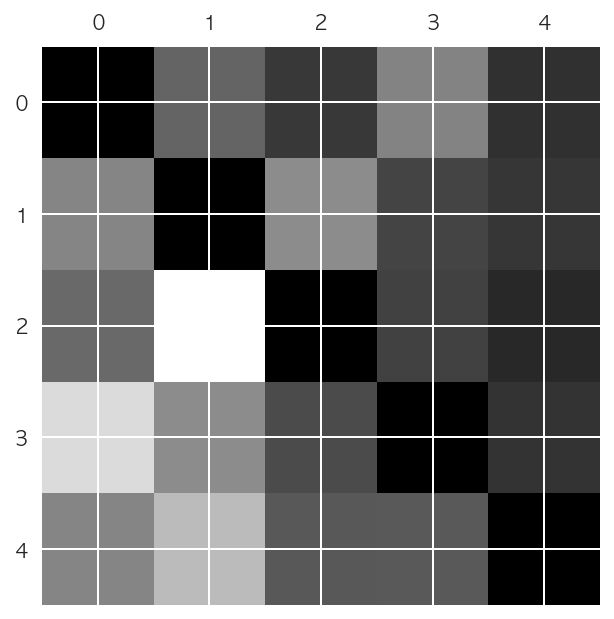

In [34]:
row_sums2 = conf_mx2.sum(axis=1, keepdims=True)
norm_conf_mx2 = conf_mx2 / row_sums2

np.fill_diagonal(norm_conf_mx2, 0)
plt.figure(figsize=(5, 5))
plt.matshow(norm_conf_mx2, cmap=plt.cm.gray, fignum=1)
plt.show()

In [35]:
test_disgust = []
for sentence, tag in zip(X_test2, y_test2):
    if tag == 2:
        test_disgust.append(sentence)
        
test_joy_predict2 = []
for sentence, tag in zip(X_test2, y_pred2):
    if tag == 0:
        test_joy_predict2.append(sentence)
        
predict_disgust_joy = list(set(test_joy_predict2).intersection(set(test_disgust)))

In [36]:
for _, sent in enumerate(predict_disgust_joy[:100:10]):
    pprint(sent)

('처음/Noun 접/Noun 하다/Verb 프랑스/Noun 코미디/Noun 의/Josa 느낌/Noun 은/Josa 꽤/Noun '
 '괜찮다/Adjective 생각/Noun 하다/Verb ./Punctuation')
'유치/Noun 하다/Verb 있다/Adjective 재미있다/Adjective 보다/Verb ㅋㅋ/KoreanParticle'
'안타깝다/Adjective 감사/Noun 하다/Verb ../Punctuation'
('"""/Punctuation 삼류/Noun 드라마/Noun 처럼/Josa 딱/VerbPrefix 딱/VerbPrefix 떨어지다/Verb '
 '영화/Noun 들/Suffix 을/Josa 비웃다/Verb 매력/Noun 적/Suffix 인/Josa 영화/Noun '
 './Punctuation 연기/Noun 대결/Noun 만으로도/Josa 시간/Noun 가다/Verb 모르다/Verb 보다/Verb '
 './Punctuation 한정/Noun 되다/Verb 공간/Noun ,/Punctuation 단/Noun 두/Determiner '
 '사람/Noun 뿐/Suffix 인/Josa 캐스팅/Noun 만으로도/Josa 영화/Noun 가/Josa 꽉/Noun 찬/Noun '
 '느낌/Noun ."""/Punctuation')
('만화책/Noun 을/Josa 보다/Verb 듯/Noun 한/Josa 영화/Noun 다소/Noun 유치/Noun 하다/Verb '
 '하다/Verb ./Punctuation 그렇지만/Conjunction 사랑스럽다/Adjective 이/Noun 봄/Noun 에/Josa '
 '자다/Verb 어울리다/Verb 귀엽다/Adjective 이야기/Noun')
('"""/Punctuation 배우/Noun 의/Josa 중요성/Noun 을/Josa 깨닫다/Verb 해주다/Verb 영화/Noun '
 './Punctuation 어색하다/Adjective 설정/Noun ,/Punctuation 배우/Noun ,/Punctuation